In [1]:
import torch
import numpy as np
import pandas as pd
from itertools import product
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(32, 32)),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

c:\Users\Vasily\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


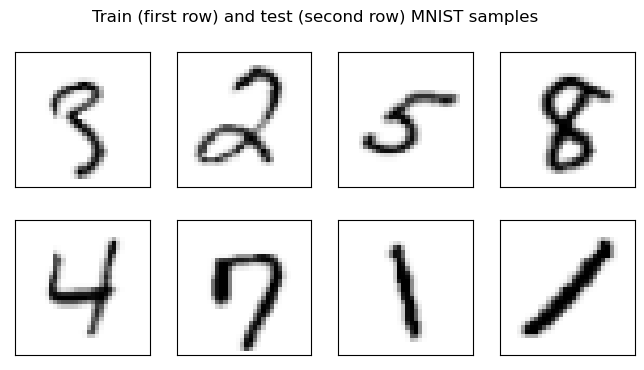

In [4]:
train_sample_ids = torch.randint(0, len(train_dataset), (4,))
test_sample_ids = torch.randint(0, len(test_dataset), (4,))

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Train (first row) and test (second row) MNIST samples")

for i, (train_id, test_id) in enumerate(zip(train_sample_ids, test_sample_ids)):
    ax[0, i].imshow(train_dataset[train_id][0][0, ...], cmap="Greys")
    ax[1, i].imshow(test_dataset[test_id][0][0, ...], cmap="Greys")

for i, j in product(range(2), range(4)):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

In [5]:
vgg11 = models.vgg11()
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [6]:
def freeze(module: torch.nn.Module):
    for param in module.parameters():
        param.requires_grad = False
    module.eval()

def unfreeze(module: torch.nn.Module):
    for param in module.parameters():
        param.requires_grad = True
    module.train()

In [7]:
def count_parameters(model: torch.nn.Module):
    total_params = 0
    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()

    return total_params

In [8]:
total_params = count_parameters(vgg11)
nn_blocks = {
    "features" : vgg11.features,
    "avgpool" : vgg11.avgpool,
    "classifier" : vgg11.classifier
}
df = pd.DataFrame(
    index=nn_blocks.keys(),
    data={
        "num_features" : [ count_parameters(block) for block in nn_blocks.values() ],
        "%_features" : [ 100.0 * count_parameters(block) / total_params for block in nn_blocks.values() ]
    }
)

In [9]:
print(f"Total parameters for VGG11: {total_params}")
df

Total parameters for VGG11: 132863336


,num_features,%_features
features,9220480,6.939823
avgpool,0,0.000000
classifier,123642856,93.060177
